## copy of environment class

TODO: reproduce work from agent based here

In [1]:
import gym
from gym import spaces
from typing import Optional
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
import os
import glob
import logging
import json
import random
import time
import torch
from collections import Counter
from typing import Optional
sns.set_theme()


def restructure_edges(network):
    """
    This function restructures the edges from list of dicts
    to one dict, to improve construction of edges matrix and 
    env vectorization
    """

    new_edges= {'source_id':[],'target_id':[],'reward':[]}
    for e in network['edges']:
        new_edges['source_id'].append(e['source_id'])
        new_edges['target_id'].append(e['target_id'])
        new_edges['reward'].append(e['reward'])
    return new_edges 


class Reward_Network(gym.Env):
    
    def __init__(self, network, to_log=False):
        
        #-------------
        # assert tests TODO
        #-------------

        # reward network information from json file (can be just one network or multiple networks)
        self.network = network
       
        # initial reward and step values
        self.INIT_REWARD = 0
        self.INIT_STEP = 0
        self.MAX_STEP = 8
        self.N_NODES = 10
        self.N_NETWORKS = len(self.network)

        # define node numbers (from 0 to 9)
        self.nodes = torch.stack([torch.arange(10)]*self.N_NETWORKS,dim = 0)
        # define starting nodes
        self.starting_nodes = torch.tensor(list(map(lambda n: n['starting_node'], self.network)), dtype=torch.long)
        # define possible rewards along with corresponding reward index
        self.possible_rewards = {-100:1, -20:2, 0:3, 20:4, 140:5}

        # initialize action space ("reward adjacency matrix")
        # NOTE intially I thought about the value 0 to be the value that signals that there is no edge between two nodes,
        # however since 0 is also a possible reward I have put 1 as the value in the reward adjacency matrix that represents
        # no edge between two nodes
        self.buffer_action_space = torch.full((self.N_NODES, self.N_NODES), 1).long()  
        self.action_space = torch.full((self.N_NETWORKS,self.N_NODES, self.N_NODES), 1).long()  
        self.new_edges = list(map(restructure_edges,network))
        self.network_idx = torch.arange(self.N_NETWORKS, dtype=torch.long)
        for n in range(self.N_NETWORKS):
            source = torch.tensor(self.new_edges[n]['source_id']).long()
            target = torch.tensor(self.new_edges[n]['target_id']).long()
            reward = torch.tensor(self.new_edges[n]['reward']).long()
            self.buffer_action_space[source,target]=reward
            self.action_space[n,:,:] = self.buffer_action_space


        # get adjacency matrix with reward index instead of actual reward
        # 0 here means that no edge is present, all other indices from 1 to 5 indicate a reward
        # (the higher the index number, the higher the reward)
        # (using this solution for now: https://discuss.pytorch.org/t/mapping-values-in-a-tensor/117731)
        self.action_space_idx = self.action_space.detach().clone()
        self.action_space_idx.apply_(lambda val: self.possible_rewards.get(val, 0))

        # boolean adjacency matrix 
        self.edge_is_present = torch.squeeze(torch.unsqueeze(self.action_space!=1,dim=-1))
        
        #self.all_edges_source = [torch.where(self.action_space[i,:,:]!=1)[0] for i in range(self.N_NETWORKS)] 
        #self.all_edges_target = [torch.where(self.action_space[i,:,:]!=1)[1] for i in range(self.N_NETWORKS)] 
        


    def reset(self):
        # Reset the state of the environment to an initial state
        self.reward_balance = torch.full((self.N_NETWORKS,1),self.INIT_REWARD)
        self.step_counter = torch.full((self.N_NETWORKS,1),self.INIT_STEP)
        self.is_done = False 
        self.current_node = self.starting_nodes.clone()
        #self.current_node = torch.tensor(list(map(lambda n: n['starting_node'], self.network)), dtype=torch.long)

        print('Environment initialized: \n')
        print(f'- set of nodes of shape {self.nodes.shape}')
        print(f'- action space of shape {self.action_space.shape}')
        print(f'- reward balance of shape {self.reward_balance.shape}')
        print(f'- step counter of shape {self.step_counter.shape}')
        print(f'- current node of shape {self.current_node.shape}')

    
    def step(self, action):
        '''
        Take a step in all environments; here action corresponds to the target nodes for each env
        action_i \in [0,1,2,3,4,5,6,7,8,9]
        '''

        self.source_node = self.current_node
        print(f'Source nodes are: {self.current_node}, we are going to new nodes {action}')

        self.rewards = torch.unsqueeze(self.action_space[self.network_idx,self.current_node,action], dim=-1)

        # TODO remove; only used to validate the equivalence during development
        #rewards_old = torch.unsqueeze( torch.tensor([self.action_space[i,self.current_node[i],action[i]] for i in range(self.N_NETWORKS)]), dim=-1)
        #torch.testing.assert_close(self.rewards, rewards_old)
        # remove end

        print(f'\n')
        self.reward_balance = torch.add(self.reward_balance,self.rewards)
        print(f'We get rewards : {self.rewards[:,0]} and the new reward balance is: {self.reward_balance[:,0]}')
        self.current_node = action
        print(f'Now we are in nodes: {self.current_node}')
        self.step_counter = torch.add(self.step_counter,1)
        print(f'Step counter for all networks is: {self.step_counter[:,0]}')
        print('\n')

        if torch.all(self.step_counter == 8):
            self.is_done = True

        return self.rewards
        
        
    def get_state(self):
        """
        this function returns the current state of the environment.
        State information given by this funciton is less detailed compared
        to the observation. 
        """
        return {'current_node':self.current_node,
                'total_reward':self.reward_balance,
                'n_steps':self.step_counter,
                'done':self.is_done}


    def get_possible_rewards(self,obs):
        """
        this function returns the next possible rewards given an observation;
        the rewards are selected using boolean masking, and the resulting array is split
        into sub-tensors whose size is given by how many valid edges are present in each network
        in the current observation.
        """
        self.n_rewards_per_network = torch.count_nonzero(obs['next_possible_nodes'],dim=1).tolist()
        self.next_rewards_all = torch.masked_select(obs['next_possible_rewards'][self.network_idx],obs['next_possible_nodes'][self.network_idx])
        self.next_rewards_per_network = torch.split(self.next_rewards_all,self.n_rewards_per_network)
        
        return self.next_rewards_per_network

    def observe(self):
        """
        TODO: CHANGE FOR VECTORIZATION
        this function returns observation from the environment
        """
        #self.valid_edges_source = [torch.where(self.all_edges_source[i]==self.current_node[i])[:] for i in range(self.N_NETWORKS)]
        #self.valid_edges_target = [self.all_edges_target[i][self.valid_edges_source[i]] for i in range(self.N_NETWORKS)]
        
        self.next_nodes = torch.squeeze(torch.unsqueeze(self.edge_is_present[self.network_idx,self.current_node,:],dim=-1))
        self.next_rewards = torch.squeeze(torch.unsqueeze(self.action_space[self.network_idx,self.current_node,:],dim=-1))
        self.next_rewards_idx = torch.squeeze(torch.unsqueeze(self.action_space_idx[self.network_idx,self.current_node,:],dim=-1))

        return {'current_node':self.current_node,
                'next_possible_nodes':self.next_nodes,#torch.squeeze(torch.unsqueeze(self.next_nodes[self.network_idx,self.network_idx,:],dim=-1)) ,
                'next_possible_rewards':self.next_rewards, #torch.squeeze(torch.unsqueeze(self.next_rewards[self.network_idx,self.network_idx,:],dim=-1)),
                'next_possible_rewards_idx':self.next_rewards_idx,
                'total_reward':self.reward_balance,
                'n_steps':self.step_counter,
                'done':self.is_done}

/Users/levinbrinkmann/repros/reward-network-iii-algorithm/.venv/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/levinbrinkmann/repros/reward-network-iii-algorithm/.venv/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/levinbrinkmann/repros/reward-network-iii-algorithm/.venv/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/levinbrinkmann/repros/reward-network-iii-algorithm/.venv/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersio

## Agent that uses pytorch functions to solve multiple environments

In [2]:
class Agent:

    def __init__(self,strategy: str, n_envs: int):
        """
        initialize agent
        """
        assert strategy in ['random','highest_payoff','take_first_loss'], f'a strategy {strategy} was given, but availabe strategies are {["random","highest_payoff","take_loss"]}'
        assert n_envs>0, f'Invalid number of environments, must be at least 1'
        
        self.strategy = strategy
        self.n_envs = n_envs
        self.possible_rewards = {-100:1, -20:2, 0:3, 20:4, 140:5}
        self.large_loss_idx = 1

        # initialize loss counter for loss strategy
        if strategy=='take_first_loss':
            self.loss_counter=torch.zeros(self.n_envs)

        self.env_index = torch.arange(0, self.n_envs, 1)

    def choose_action(self,obs):
        """
        Choose next action given an observation and a strategy
        """
        print(f"Shape of the next possible rewards (index) matrix: {obs['next_possible_rewards_idx'].shape}")
        next_action = torch.zeros(self.n_envs,dtype=torch.long)

        #-----RANDOM------
        random_action = torch.squeeze(torch.multinomial(obs['next_possible_nodes'].type(torch.float),1))

        #-----HIGHEST PAYOFF------
        max_avaible_reward_idx = torch.max(obs['next_possible_rewards_idx'],dim=1)[0]
        p = torch.squeeze(
            obs['next_possible_rewards_idx'].unsqueeze(0) == self.max_avaible_reward_idx.unsqueeze(1),dim=0)
        highest_payoff_action = torch.squeeze(torch.multinomial(p.type(torch.float),1))

        #-----TAKE FIRST LARGE LOSS------
        min_avaible_reward_idx = torch.max(obs['next_possible_rewards_idx'],dim=1)[0]
        large_loss_is_avaible = min_avaible_reward_idx == self.large_loss_idx
        take_large_loss = (self.loss_counter == 0) & large_loss_is_avaible
        
        # actions for those cases, where we want to take a large loss
        p = torch.squeeze(
            obs['next_possible_rewards_idx'][take_large_loss].unsqueeze(0) == self.large_loss_idx,dim=0)
        large_loss_action = torch.squeeze(torch.multinomial(p.type(torch.float),1))

        first_large_loss_action = highest_payoff_action.copy()
        first_large_loss_action[take_large_loss] = large_loss_action
        self.loss_counter += take_large_loss.astype(int)

        if self.strategy=='random':
            next_action = random_action
        elif self.strategy=='highest_payoff':
            next_action = highest_payoff_action
        elif self.strategy=='take_first_loss':
            next_action = first_large_loss_action
        
        return next_action

## load a few networks and test (with random policy)

In [3]:
project_folder = "../.."
data_dir = os.path.join(project_folder,'data','rawdata')

with open(os.path.join(data_dir,'train.json')) as json_file:
    train = json.load(json_file)

test = train[10:13]

FileNotFoundError: [Errno 2] No such file or directory: '../../data/rawdata/train.json'

In [ ]:
N = Reward_Network(test)
A = Agent('take_first_loss',len(test))
N.reset()

Environment initialized: 

- set of nodes of shape torch.Size([3, 10])
- action space of shape torch.Size([3, 10, 10])
- reward balance of shape torch.Size([3, 1])
- step counter of shape torch.Size([3, 1])
- current node of shape torch.Size([3])


In [ ]:
N.action_space[0,:,:]

tensor([[   1,    1,    1,   20,  -20,    1,    1,    1,    1,    1],
        [   1,    1,  -20,   20,    1,    1,    1,    1,    1,    1],
        [  20,    1,    1,    1,    1,    1, -100,    1,    1,    1],
        [   1,    0,    1,    1,   20,    1,    1,    1,    1,    1],
        [   0,   20,    1,    1,    1,    1,    1,    1,    1,    1],
        [   1,    1,    1,    1,    1,    1,    0,    1,   20,    1],
        [   1,    1,    1,    1,    1,    1,    1,   20,    0,    1],
        [   1,    1,    1,    1,    1,    0,    1,    1,    1,   20],
        [   1,    1,    1,    1,    1,  -20,    1,    0,    1,    1],
        [   1,    1,   20,    1,    1,    1,    1,    1,  140,    1]])

In [ ]:
N.observe()

{'current_node': tensor([0, 0, 0]),
 'next_possible_nodes': tensor([[False, False, False,  True,  True, False, False, False, False, False],
         [False, False, False,  True,  True, False,  True, False, False, False],
         [False, False,  True,  True,  True, False,  True, False, False, False]]),
 'next_possible_rewards': tensor([[   1,    1,    1,   20,  -20,    1,    1,    1,    1,    1],
         [   1,    1,    1,  -20,  -20,    1, -100,    1,    1,    1],
         [   1,    1,  -20,  -20,   20,    1, -100,    1,    1,    1]]),
 'next_possible_rewards_idx': tensor([[0, 0, 0, 4, 2, 0, 0, 0, 0, 0],
         [0, 0, 0, 2, 2, 0, 1, 0, 0, 0],
         [0, 0, 2, 2, 4, 0, 1, 0, 0, 0]]),
 'total_reward': tensor([[0],
         [0],
         [0]]),
 'n_steps': tensor([[0],
         [0],
         [0]]),
 'done': False}

In [ ]:
# NEW: Using the observation to step in the environment
outputs = []
while N.is_done==False:
    print(f'Current node in the envs: {N.current_node}')
    print('---------------------------------------------')

    obs = N.observe()
    possible_rewards = N.get_possible_rewards(obs)

    # select action based on observation
    next_action = A.choose_action(obs)
    print(f'Next actions chosen: {next_action}')
    # take a step in envs
    rewards = N.step(next_action)
    #print(f'rewards: {rewards} with size {rewards.shape}')
    outputs.append(rewards)

results = torch.squeeze(torch.stack(outputs,dim=1),dim=-1)
results.shape

Current node in the envs: tensor([0, 0, 0])
---------------------------------------------
Shape of the next possible rewards (index) matrix: torch.Size([3, 10])
LOSS COUNTER tensor([0., 0., 0.])
For which envs is the loss counter 0? tensor([0, 1, 2]) of length 3
For which envs is the loss counter 1? tensor([], dtype=torch.int64) of length 0
In which envs do we find a -100 loss in next step? tensor([1, 2])
intersection: tensor([1, 2]) and difference tensor([0])
tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])
intersection loss action at env index tensor([1, 2]) -> tensor([6, 6])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
the_max_elements_per_row (for envs whose loss counter is still 0 but no -100 resent) tensor([4])
tensor([[0, 0, 0, 4, 2, 0, 0, 0, 0, 0]])
tensor([4])
p diff: tensor([[False, False, False,  True, False, False, False, False, False, False]])
loss counter now: tensor([0., 1., 1.])


final next action: tensor([3, 6, 6])
Next actions chosen: tens

torch.Size([3, 8])

## Replicate results from agent based notebook

In [ ]:
network_ids = [i['network_id'] for i in train]

In [ ]:
N = Reward_Network(train)
A = Agent('highest_payoff',len(train))
N.reset()

# HIGHEST PAYOFF
outputsA = []

while N.is_done==False:
    print(f'Current node in the envs: {N.current_node}')
    print('---------------------------------------------')

    obs = N.observe()
    possible_rewards = N.get_possible_rewards(obs)
    
    # select action based on observation
    next_actionA = A.choose_action(obs)
    print(f'Next actions chosen: {next_actionA}')
    # take a step in envs
    rewards = N.step(next_actionA)
    outputsA.append(rewards)

resultsA = torch.squeeze(torch.stack(outputsA,dim=1),dim=-1)
print(f'FINISHED! We obtain a results tensor of shape {resultsA.shape}')
resultsA_df = pd.DataFrame(resultsA.numpy(), columns = [f'reward_{i}' for i in range(1,9)])

Environment initialized: 

- set of nodes of shape torch.Size([945, 10])
- action space of shape torch.Size([945, 10, 10])
- reward balance of shape torch.Size([945, 1])
- step counter of shape torch.Size([945, 1])
- current node of shape torch.Size([945])
Current node in the envs: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
N = Reward_Network(train)
B = Agent('take_first_loss',len(train))
N.reset()


# TAKE FIRST LOSS
outputsB = []
while N.is_done==False:
    print(f'Current node in the envs: {N.current_node}')
    print('---------------------------------------------')

    obs = N.observe()
    possible_rewards = N.get_possible_rewards(obs)
    
    # select action based on observation
    next_actionB = B.choose_action(obs)
    print(f'Next actions chosen: {next_actionB}')
    # take a step in envs
    rewards = N.step(next_actionB)
    outputsB.append(rewards)

resultsB = torch.squeeze(torch.stack(outputsB,dim=1),dim=-1)
print(f'FINISHED! We obtain a results tensor of shape {resultsB.shape}')
resultsB_df = pd.DataFrame(resultsB.numpy(), columns = [f'reward_{i}' for i in range(1,9)])

Environment initialized: 

- set of nodes of shape torch.Size([945, 10])
- action space of shape torch.Size([945, 10, 10])
- reward balance of shape torch.Size([945, 1])
- step counter of shape torch.Size([945, 1])
- current node of shape torch.Size([945])
Current node in the envs: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
N = Reward_Network(train)
C = Agent('random',len(train))
N.reset()


# RANDOM
outputsC = []
while N.is_done==False:
    print(f'Current node in the envs: {N.current_node}')
    print('---------------------------------------------')

    obs = N.observe()
    possible_rewards = N.get_possible_rewards(obs)
    
    # select action based on observation
    next_actionC = C.choose_action(obs)
    print(f'Next actions chosen: {next_actionC}')
    # take a step in envs
    rewards = N.step(next_actionC)
    outputsC.append(rewards)

resultsC = torch.squeeze(torch.stack(outputsC,dim=1),dim=-1)
print(f'FINISHED! We obtain a results tensor of shape {resultsC.shape}')
resultsC_df = pd.DataFrame(resultsC.numpy(), columns = [f'reward_{i}' for i in range(1,9)])

Environment initialized: 

- set of nodes of shape torch.Size([945, 10])
- action space of shape torch.Size([945, 10, 10])
- reward balance of shape torch.Size([945, 1])
- step counter of shape torch.Size([945, 1])
- current node of shape torch.Size([945])
Current node in the envs: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Transform Tensor results to Dataframe

In [ ]:
# add network ids
resultsA_df.insert(loc=0, column='network_id', value=network_ids)
resultsB_df.insert(loc=0, column='network_id', value=network_ids)
resultsC_df.insert(loc=0, column='network_id', value=network_ids)

# add cumulative reward column
resultsA_df['total_reward'] = resultsA_df.sum(axis=1)
resultsA_df.head(30)

/var/folders/bf/1wzkxhv923145cbh3xbz51kh0000gr/T/ipykernel_9045/2537788698.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  resultsA_df['total_reward'] = resultsA_df.sum(axis=1)


,network_id,reward_1,reward_2,reward_3,reward_4,reward_5,reward_6,reward_7,reward_8,total_reward
0,612d020c2855f861544a66ea4a8663c4,-20,0,20,20,0,20,20,0,60
1,fc97ced304cff0b64894d2a6bbbfc142,20,20,20,0,20,0,20,0,100
2,8bae2ee9bab910a86f1f97619c84bde7,20,20,20,20,20,20,20,20,160
3,1636fe1921b59a7403f96d8f8f1fcba2,20,20,20,20,20,20,20,20,160
4,988a9097dd397e8bfd0f8d219d04d362,20,0,20,0,20,0,20,0,80
5,f928fa70b461d74873bee961b1b54d79,20,20,20,0,20,20,20,20,140
6,2e88b4462adfdc5a85fee6301df3c574,20,20,20,20,20,140,20,140,400
7,bc6e64aacaaecdde815fa2f52ae9a08f,0,20,0,20,0,20,20,20,100
8,d601e40cf010d37c451e09b3dd349bca,20,20,20,0,20,0,20,20,120
9,17256a66eef2c9f467a33108a59c5b09,20,20,20,20,20,20,20,20,160


In [ ]:
resultsA_df[resultsA_df['network_id']=='e9856335f1991c452c677222a4314d9f']

,network_id,reward_1,reward_2,reward_3,reward_4,reward_5,reward_6,reward_7,reward_8,total_reward
163,e9856335f1991c452c677222a4314d9f,20,20,20,20,20,20,20,20,160


In [ ]:
resultsB_df['total_reward'] = resultsB_df.sum(axis=1)
resultsB_df.head(30)

/var/folders/bf/1wzkxhv923145cbh3xbz51kh0000gr/T/ipykernel_9045/2101493446.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  resultsB_df['total_reward'] = resultsB_df.sum(axis=1)


,network_id,reward_1,reward_2,reward_3,reward_4,reward_5,reward_6,reward_7,reward_8,total_reward
0,612d020c2855f861544a66ea4a8663c4,-100,0,20,20,140,20,140,20,260
1,fc97ced304cff0b64894d2a6bbbfc142,-100,0,20,20,0,20,20,20,0
2,8bae2ee9bab910a86f1f97619c84bde7,-100,20,20,20,20,140,20,20,160
3,1636fe1921b59a7403f96d8f8f1fcba2,-100,20,20,20,20,20,20,20,40
4,988a9097dd397e8bfd0f8d219d04d362,-100,20,20,20,140,20,20,20,160
5,f928fa70b461d74873bee961b1b54d79,-100,20,140,20,20,20,20,20,160
6,2e88b4462adfdc5a85fee6301df3c574,-100,20,20,20,20,20,140,20,160
7,bc6e64aacaaecdde815fa2f52ae9a08f,-100,20,140,20,20,0,20,20,140
8,d601e40cf010d37c451e09b3dd349bca,-100,20,20,20,20,140,20,20,160
9,17256a66eef2c9f467a33108a59c5b09,-100,0,20,140,0,20,20,0,100


In [ ]:
resultsC_df['total_reward'] = resultsC_df.sum(axis=1)
resultsC_df.head(30)

/var/folders/bf/1wzkxhv923145cbh3xbz51kh0000gr/T/ipykernel_9045/3557286971.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  resultsC_df['total_reward'] = resultsC_df.sum(axis=1)


,network_id,reward_1,reward_2,reward_3,reward_4,reward_5,reward_6,reward_7,reward_8,total_reward
0,612d020c2855f861544a66ea4a8663c4,-100,0,-20,20,0,20,-20,0,-100
1,fc97ced304cff0b64894d2a6bbbfc142,20,20,-20,20,20,0,20,-100,-20
2,8bae2ee9bab910a86f1f97619c84bde7,-100,0,20,-100,20,20,20,-20,-140
3,1636fe1921b59a7403f96d8f8f1fcba2,-100,20,0,-20,-100,-20,-20,-100,-340
4,988a9097dd397e8bfd0f8d219d04d362,-100,0,0,140,0,20,0,20,80
5,f928fa70b461d74873bee961b1b54d79,20,0,-20,-100,0,20,140,-100,-40
6,2e88b4462adfdc5a85fee6301df3c574,-100,0,-20,-100,0,-20,20,0,-220
7,bc6e64aacaaecdde815fa2f52ae9a08f,-100,20,140,20,0,20,-20,-100,-20
8,d601e40cf010d37c451e09b3dd349bca,20,-100,-20,0,140,20,0,0,60
9,17256a66eef2c9f467a33108a59c5b09,-100,0,-20,20,-20,0,-20,-20,-160


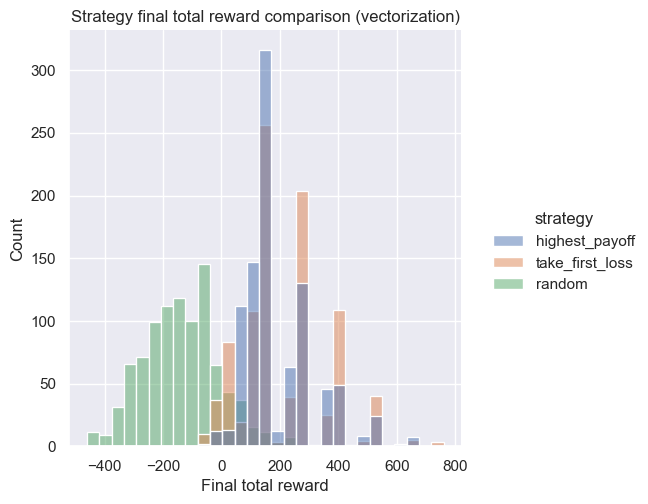

In [ ]:
resultsA_df['strategy'] = 'highest_payoff'
resultsB_df['strategy'] = 'take_first_loss'
resultsC_df['strategy'] = 'random'

strategy_data_final=pd.concat([resultsA_df[['network_id','strategy','total_reward']],
                               resultsB_df[['network_id','strategy','total_reward']],
                               resultsC_df[['network_id','strategy','total_reward']]], ignore_index=True)

# hist plot
g=sns.displot(data=strategy_data_final, x="total_reward", hue="strategy", kind="hist")
g.set(xlabel='Final total reward',ylabel='Count',title=f'Strategy final total reward comparison (vectorization)')
plt.show()

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
    group1          group2      meandiff p-adj    lower     upper   reject
--------------------------------------------------------------------------
highest_payoff          random -336.7831    0.0 -350.8067 -322.7595   True
highest_payoff take_first_loss   16.4021 0.0169    2.3785   30.4257   True
        random take_first_loss  353.1852    0.0  339.1616  367.2088   True
--------------------------------------------------------------------------


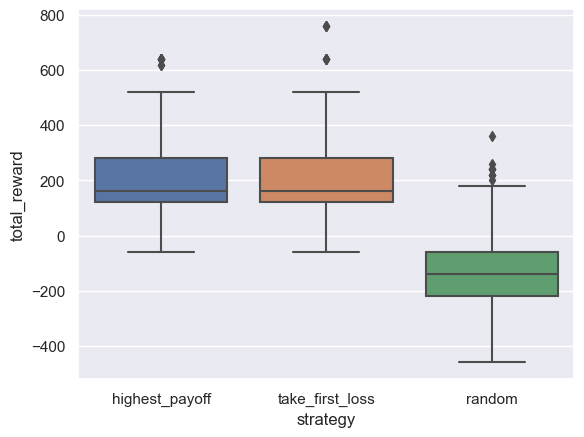

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=strategy_data_final['total_reward'],
                          groups=strategy_data_final['strategy'],
                          alpha=0.05)

#display results
print(tukey)

sns.boxplot(x="strategy", y="total_reward", data=strategy_data_final)
plt.show()

## Compare results

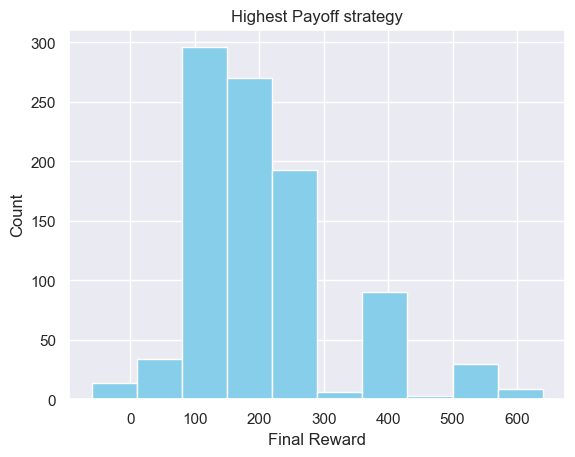

In [ ]:
colors = {'highest_payoff':'skyblue','take_first_loss':'orangered','random':'springgreen'}

a = (torch.sum(resultsA,dim=1)).numpy()
plt.hist(a,color=colors['highest_payoff'])
plt.title('Highest Payoff strategy')
plt.xlabel('Final Reward')
plt.ylabel('Count')
plt.show()

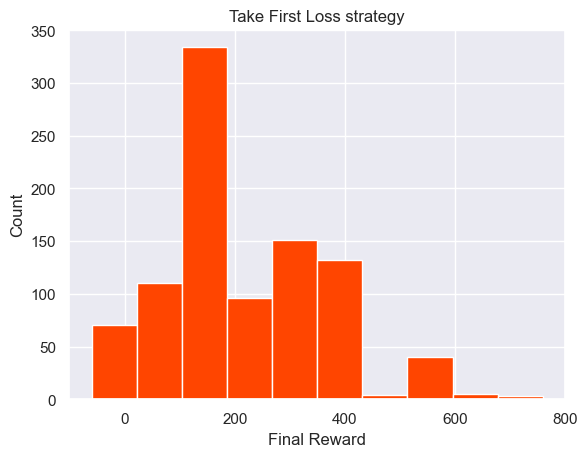

In [ ]:
b = (torch.sum(resultsB,dim=1)).numpy()
plt.hist(b,color=colors['take_first_loss'])
plt.title('Take First Loss strategy')
plt.xlabel('Final Reward')
plt.ylabel('Count')
plt.show()

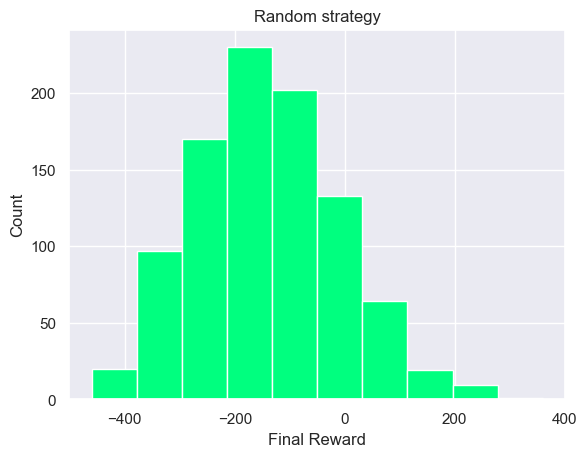

In [ ]:
c = (torch.sum(resultsC,dim=1)).numpy()
plt.hist(c,color=colors['random'])
plt.title('Random strategy')
plt.xlabel('Final Reward')
plt.ylabel('Count')
plt.show()

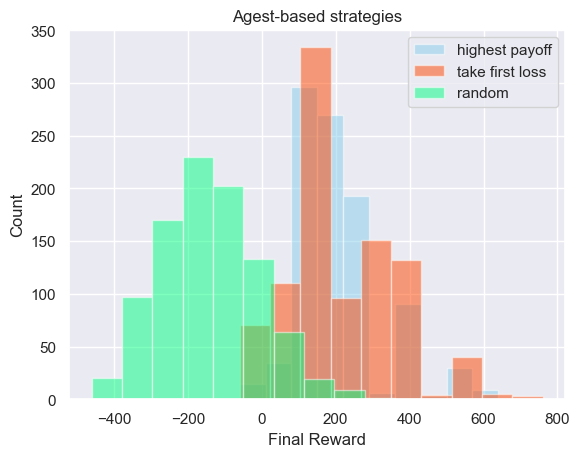

In [ ]:
plt.hist(a,color=colors['highest_payoff'],alpha=0.5,label='highest payoff')
plt.hist(b,color=colors['take_first_loss'],alpha=0.5,label='take first loss')
plt.hist(c,color=colors['random'],alpha=0.5,label='random')
plt.legend(loc='upper right')
plt.title('Agest-based strategies')
plt.xlabel('Final Reward')
plt.ylabel('Count')
plt.show()

Avg reward at each step (highest payoff): tensor([16.1905, 15.6190, 24.2963, 26.8571, 29.7354, 27.0476, 29.9048, 28.1905])
Avg reward at each step (take first loss): tensor([-100.0000,   38.1164,   75.7884,   51.2169,   39.7460,   37.9894,
          35.1323,   36.2540])
Avg reward at each step (random): tensor([-43.9153, -16.9735, -11.8942, -13.7143, -13.5238, -13.8836, -12.1905,
        -12.8466])


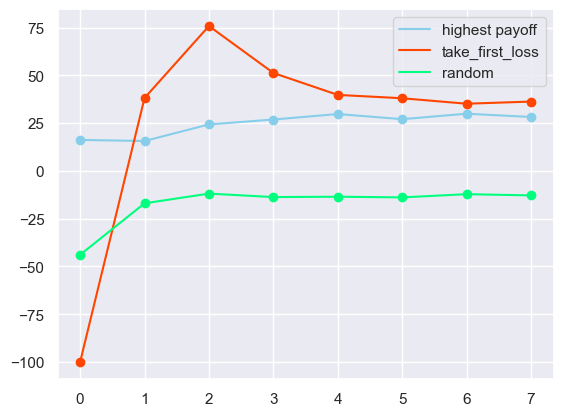

In [ ]:
meanA = resultsA.mean(dim=0,dtype=torch.float)
print(f'Avg reward at each step (highest payoff): {meanA}')
meanB = resultsB.mean(dim=0,dtype=torch.float)
print(f'Avg reward at each step (take first loss): {meanB}')
meanC = resultsC.mean(dim=0,dtype=torch.float)
print(f'Avg reward at each step (random): {meanC}')

plt.scatter(np.arange(0,8),meanA,color=colors['highest_payoff'])
plt.plot(np.arange(0,8),meanA,color=colors['highest_payoff'],label='highest payoff')
plt.scatter(np.arange(0,8),meanB,color=colors['take_first_loss'])
plt.plot(np.arange(0,8),meanB,color=colors['take_first_loss'],label='take_first_loss')
plt.scatter(np.arange(0,8),meanC,color=colors['random'])
plt.plot(np.arange(0,8),meanC,color=colors['random'],label='random')
plt.legend(loc='upper right')
plt.show()

## Try Gym.Spaces to define observation space of the environment in order to use stable-baselines3?

https://stackoverflow.com/questions/56448260/how-could-i-define-the-observation-space-for-my-custom-openai-enviroment
https://github.com/openai/gym/blob/master/gym/spaces/graph.py
https://github.com/openai/gym/issues/2912

https://stable-baselines3.readthedocs.io/en/master/common/env_checker.html (current version of env does not completely follow Gym API since we custom define the action and observation space without using the gym.spaces submodule)
https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html
https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html


The problem with the openai gym enviroments is that their space wrappers generate the action space and observation space but there doesn't seem to be much room for customization

A possibility could be to define `Tuple(Discrete(10),Discrete(10))` or `MultiDiscrete ([10,10])` for the action space, and a utility function to check if actions are valid in the current node you're at.

Observation space might be a bit trickier, should include at least current node, possible actions, step counter and done flag